To do:

1. Filter out Phase 1 trials - Done
2. Make a legible graph for all countries
3. Data grouped by quarter - Done

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from datetime import date

In [22]:
april_19 = pd.read_csv('euctr_april19.csv')

for date in ['date_of_competent_authority_decision', 
             'date_of_ethics_committee_opinion', 
             'date_on_which_this_record_was_first_entered_in_the_eudract_data']:
    april_19[date] = pd.to_datetime(april_19[date], errors='coerce')
april_19.head()

,eudract_number,eudract_number_with_country,trial_location,date_of_competent_authority_decision,date_of_ethics_committee_opinion,date_on_which_this_record_was_first_entered_in_the_eudract_data,phase_1
0,2009-017659-83,2009-017659-83-SI,SI,2010-04-08,2010-03-10,2009-12-11,0
1,2009-016752-52,2009-016752-52-SI,SI,2010-03-24,2009-11-21,2009-12-14,0
2,2004-002902-31,2004-002902-31-MT,MT,2006-08-18,2006-09-07,2006-08-21,0
3,2010-021842-23,2010-021842-23-IS,IS,2010-09-15,2010-09-14,2010-07-30,0
4,2009-018054-33,2009-018054-33-SI,SI,2010-06-21,2009-01-19,2010-04-09,0


In [16]:
trial_counts = april_19['eudract_number'].groupby(april_19.trial_location).count()
trial_counts

trial_location
3rd     1228
AT      3804
BE      5410
BG      1651
CZ      3925
DE     10383
DK      3594
EE       960
ES      8608
FI      2349
FR      4753
GB      8725
GR      1547
HR       276
HU      3991
IE      1073
IS       132
IT      7096
LT      1153
LU         7
LV       994
MT        18
NL      4951
NO       523
PL      2610
PT      1380
RO       227
SE      3630
SI       349
SK      1649
Name: eudract_number, dtype: int64

In [67]:
#This function gets the data in a place where you can graph it.
#Options:
#quarters = True will group the data per quarter. If this is False, you will get it by year.
#small_filter = True filters out countries with less than 1000 total trials on EUCTR as a default.
#You can adjust what "small" is by optionally changing the interger value of "small_def"
#thrd_filter = True will filter out all trial locations in a non EU country
#p1_filter is defaulted to true which removes all trials listed as ONLY phase 1 trials (i.e. not phase1/2)
#bad date data for any field is coerced to NaN

def process_data(data, quarters=False, small_filter=False, small_def=1000, thrd_filter=False, p1_filter=True):
    excluded_list = []
    start_quarter = pd.to_datetime('2008-01').to_period('Q')
    end_quarter = pd.to_datetime('2019-01').to_period('Q')
    if small_filter:
        trial_counts = data['eudract_number'].groupby(data.trial_location).count()
        x = list(trial_counts[trial_counts < small_def].index)
        excluded_list = excluded_list + x
    if thrd_filter:
        excluded_list.append('3rd')             
    data = data[~data.trial_location.isin(excluded_list)].reset_index(drop=True)
    if p1_filter:
        data = data[data.phase_1 == 0].reset_index(drop=True)
    data['date_of_competent_authority_decision'] = pd.to_datetime(data['date_of_competent_authority_decision'], errors='coerce')
    data['date_of_ethics_committee_opinion'] = pd.to_datetime(data['date_of_ethics_committee_opinion'], errors='coerce')
    data['date_on_which_this_record_was_first_entered_in_the_eudract_data'] = pd.to_datetime(data['date_on_which_this_record_was_first_entered_in_the_eudract_data'], errors='coerce')
    if not quarters:
        cad = data['eudract_number'].groupby([data.trial_location, data.date_of_competent_authority_decision.dt.year]).count()
        ethics = data['eudract_number'].groupby([data.trial_location, data.date_of_ethics_committee_opinion.dt.year]).count()
        entered = data['eudract_number'].groupby([data.trial_location, data.date_on_which_this_record_was_first_entered_in_the_eudract_data.dt.year]).count()
    elif quarters:
        cad = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_of_competent_authority_decision, freq='Q')]).count()
        ethics = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_of_ethics_committee_opinion, freq='Q')]).count()
        entered = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_on_which_this_record_was_first_entered_in_the_eudract_data, freq='Q')]).count()
    combined = pd.concat([cad,ethics,entered], axis=1)
    combined.columns = ['cad', 'ethics', 'entered']
    if quarters:
        combined.index.names = ['country', 'quarters']
        combined = combined.query('quarters < @end_quarter')
        combined = combined.query('quarters >= @start_quarter')
        time_i = combined.index.get_level_values(1)
    elif not quarters:
        combined.index.names = ['country', 'years']
        combined = combined.query('years < 2019')
        combined = combined.query('years >= 2008')
        time_i = combined.index.get_level_values(1).astype(int) 
    country_i = combined.index.get_level_values(0).astype(str)
    combined.index = [country_i, time_i]
    if not quarters:
        pivoted_cad = combined.reset_index().pivot('years','country','cad').fillna(0)
        pivoted_ethics = combined.reset_index().pivot('years','country','ethics').fillna(0)
        pivoted_entered = combined.reset_index().pivot('years','country','entered').fillna(0)
    elif quarters:
        pivoted_cad = combined.reset_index().pivot('quarters','country','cad').fillna(0)
        pivoted_cad.index = pivoted_cad.index.to_timestamp()
        pivoted_ethics = combined.reset_index().pivot('quarters','country','ethics').fillna(0)
        pivoted_ethics.index = pivoted_ethics.index.to_timestamp()
        pivoted_entered = combined.reset_index().pivot('quarters','country','entered').fillna(0)
        pivoted_entered.index = pivoted_entered.index.to_timestamp()
    return pivoted_cad, pivoted_ethics, pivoted_entered

In [68]:
pivoted_cad_q, pivoted_ethics_q, pivoted_entered_q = process_data(april_19, quarters=True, small_filter=True, thrd_filter=True)
pivoted_cad, pivoted_ethics, pivoted_entered = process_data(april_19, quarters=False, small_filter=True, thrd_filter=True)

In [69]:
all_pivoted_cad_q, all_pivoted_ethics_q, all_pivoted_entered_q = process_data(april_19, quarters=True, small_filter=False, thrd_filter=True)
all_pivoted_cad, all_pivoted_ethics, all_pivoted_entered = process_data(april_19, quarters=False, small_filter=False, thrd_filter=True)

In [70]:
pivoted_cad_q.columns

Index(['AT', 'BE', 'BG', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU',
       'IE', 'IT', 'LT', 'NL', 'PL', 'PT', 'SE', 'SK'],
      dtype='object', name='country')

In [71]:
pivoted_cad.head()

country,AT,BE,BG,CZ,DE,DK,ES,FI,FR,GB,GR,HU,IE,IT,LT,NL,PL,PT,SE,SK
years,,,,,,,,,,,,,,,,,,,,
2008,223.0,430.0,165.0,263.0,862.0,241.0,562.0,191.0,700.0,727.0,101.0,250.0,80.0,751.0,104.0,395.0,113.0,123.0,311.0,139.0
2009,344.0,392.0,139.0,272.0,862.0,246.0,590.0,180.0,694.0,725.0,126.0,263.0,73.0,660.0,70.0,391.0,113.0,97.0,281.0,127.0
2010,325.0,373.0,138.0,269.0,805.0,194.0,538.0,176.0,485.0,625.0,110.0,260.0,82.0,573.0,70.0,354.0,119.0,98.0,229.0,121.0
2011,283.0,358.0,163.0,310.0,841.0,251.0,622.0,146.0,141.0,631.0,112.0,305.0,60.0,562.0,93.0,299.0,164.0,82.0,265.0,152.0
2012,268.0,391.0,144.0,292.0,711.0,243.0,629.0,146.0,104.0,671.0,136.0,313.0,67.0,584.0,72.0,375.0,268.0,89.0,233.0,125.0


In [72]:
def which_countries(data, total_trials, greater_than=True, thrd_filter = True):
    inc_states = []
    trial_counts = data['eudract_number'].groupby(data.trial_location).count()
    if greater_than:
        inc = list(trial_counts[trial_counts > total_trials].index)
        inc_states = inc_states + inc
    elif not greater_than:
        inc = list(trial_counts[trial_counts < total_trials].index)
        inc_states = inc_states + inc
    if thrd_filter and '3rd' in inc_states:
        inc_states.remove('3rd')
    return inc_states

In [73]:
included = which_countries(april_19, 4000)

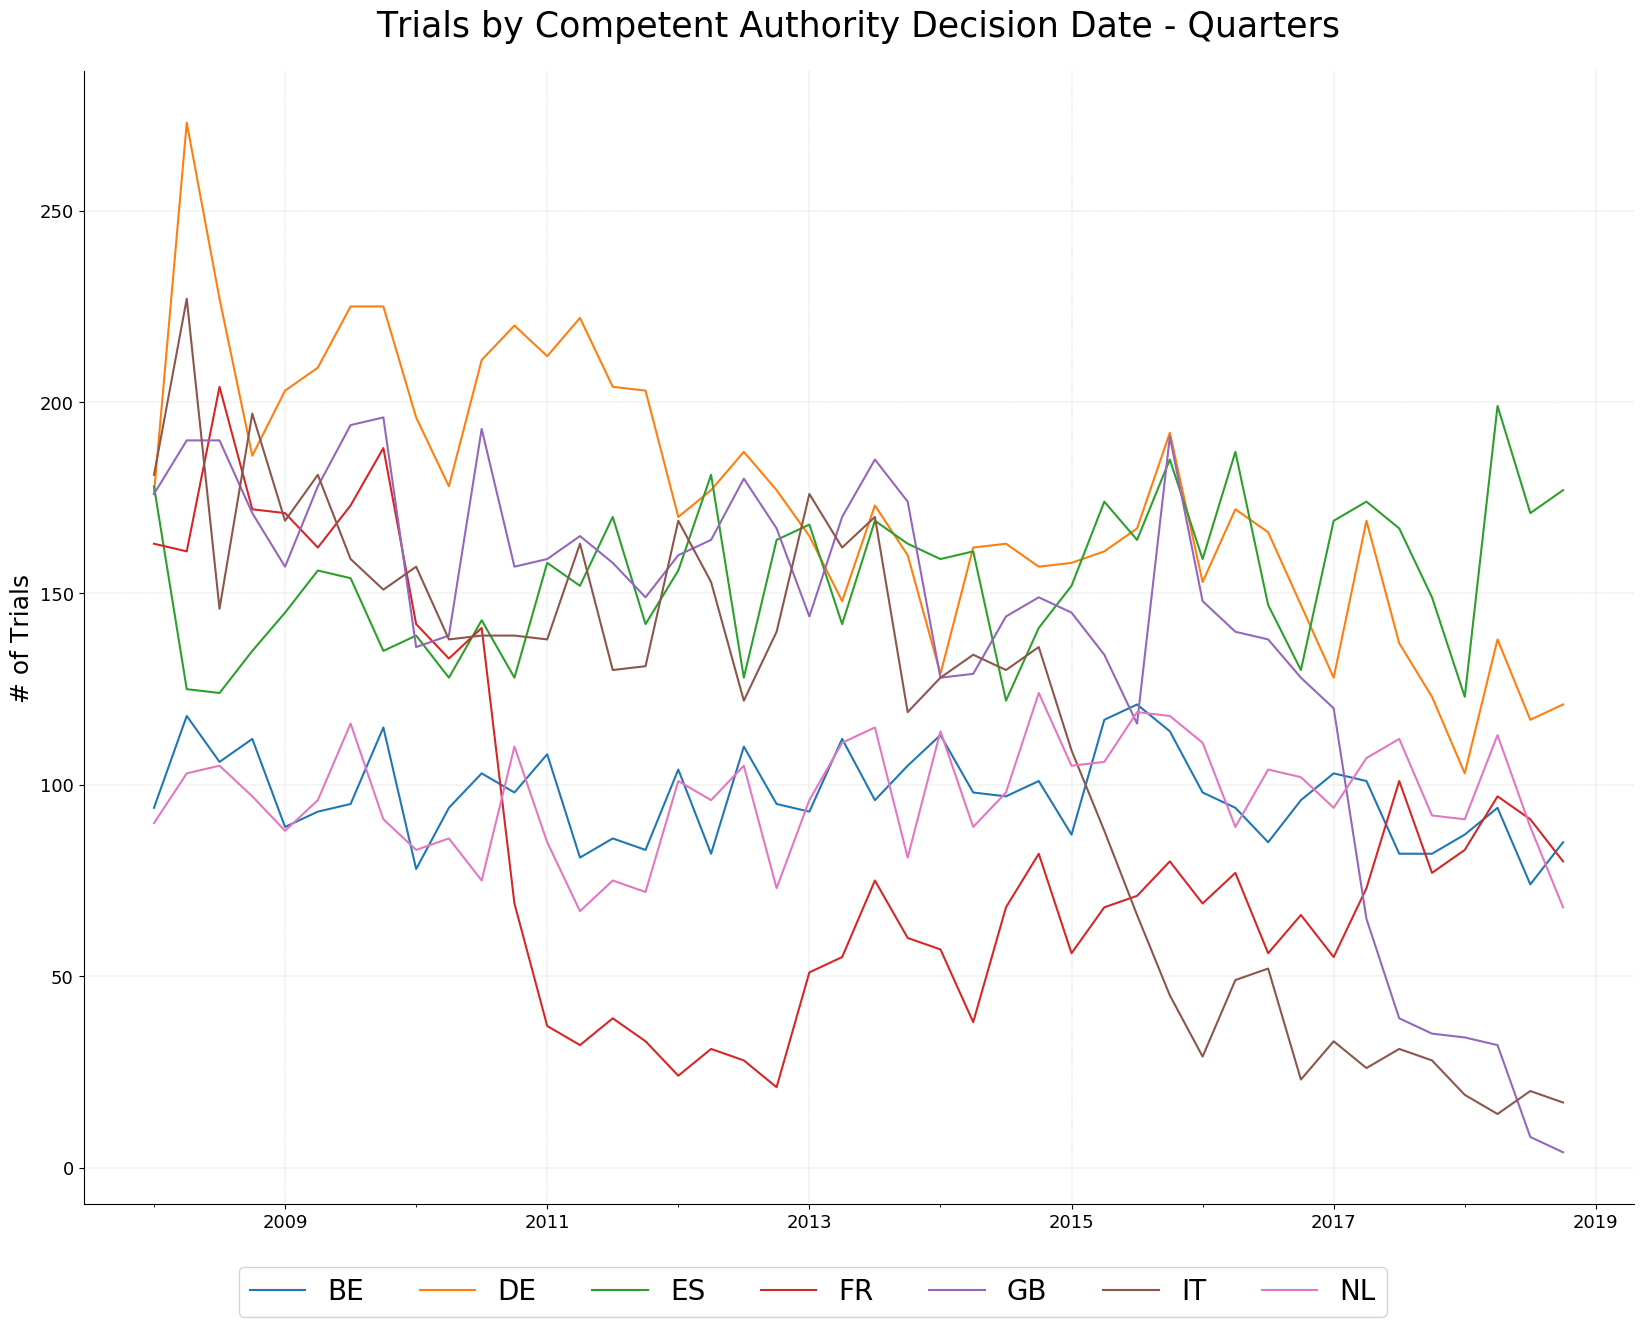

In [75]:
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
pivoted_cad_q[included].plot(ax=ax)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("Trials by Competent Authority Decision Date - Quarters", pad=25, fontsize=25)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('# of Trials', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc=(.1,-.1), ncol = 7, fontsize = 20)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
plt.show()

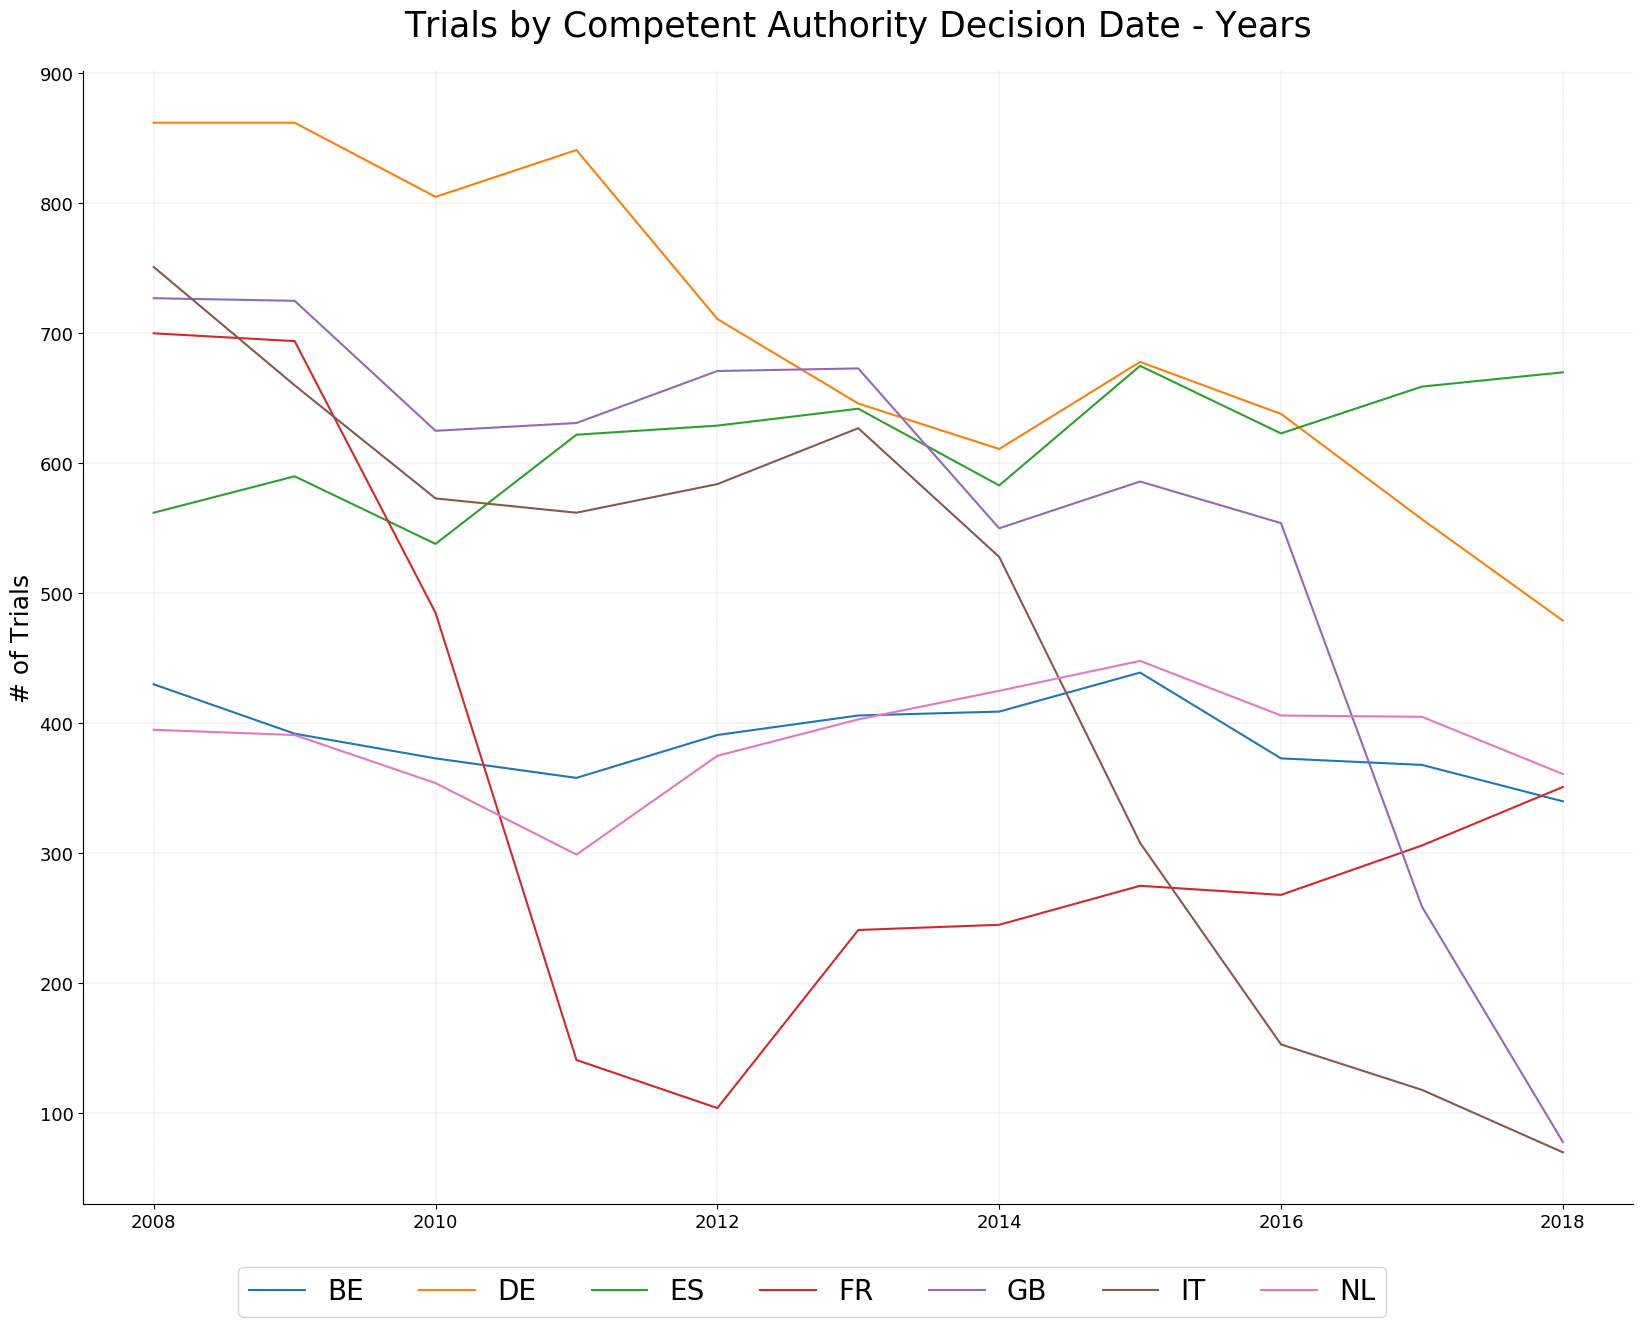

In [76]:
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
pivoted_cad[included].plot(ax=ax)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("Trials by Competent Authority Decision Date - Years", pad=25, fontsize=25)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('# of Trials', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc=(.1,-.1), ncol = 7, fontsize = 20)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
plt.show()

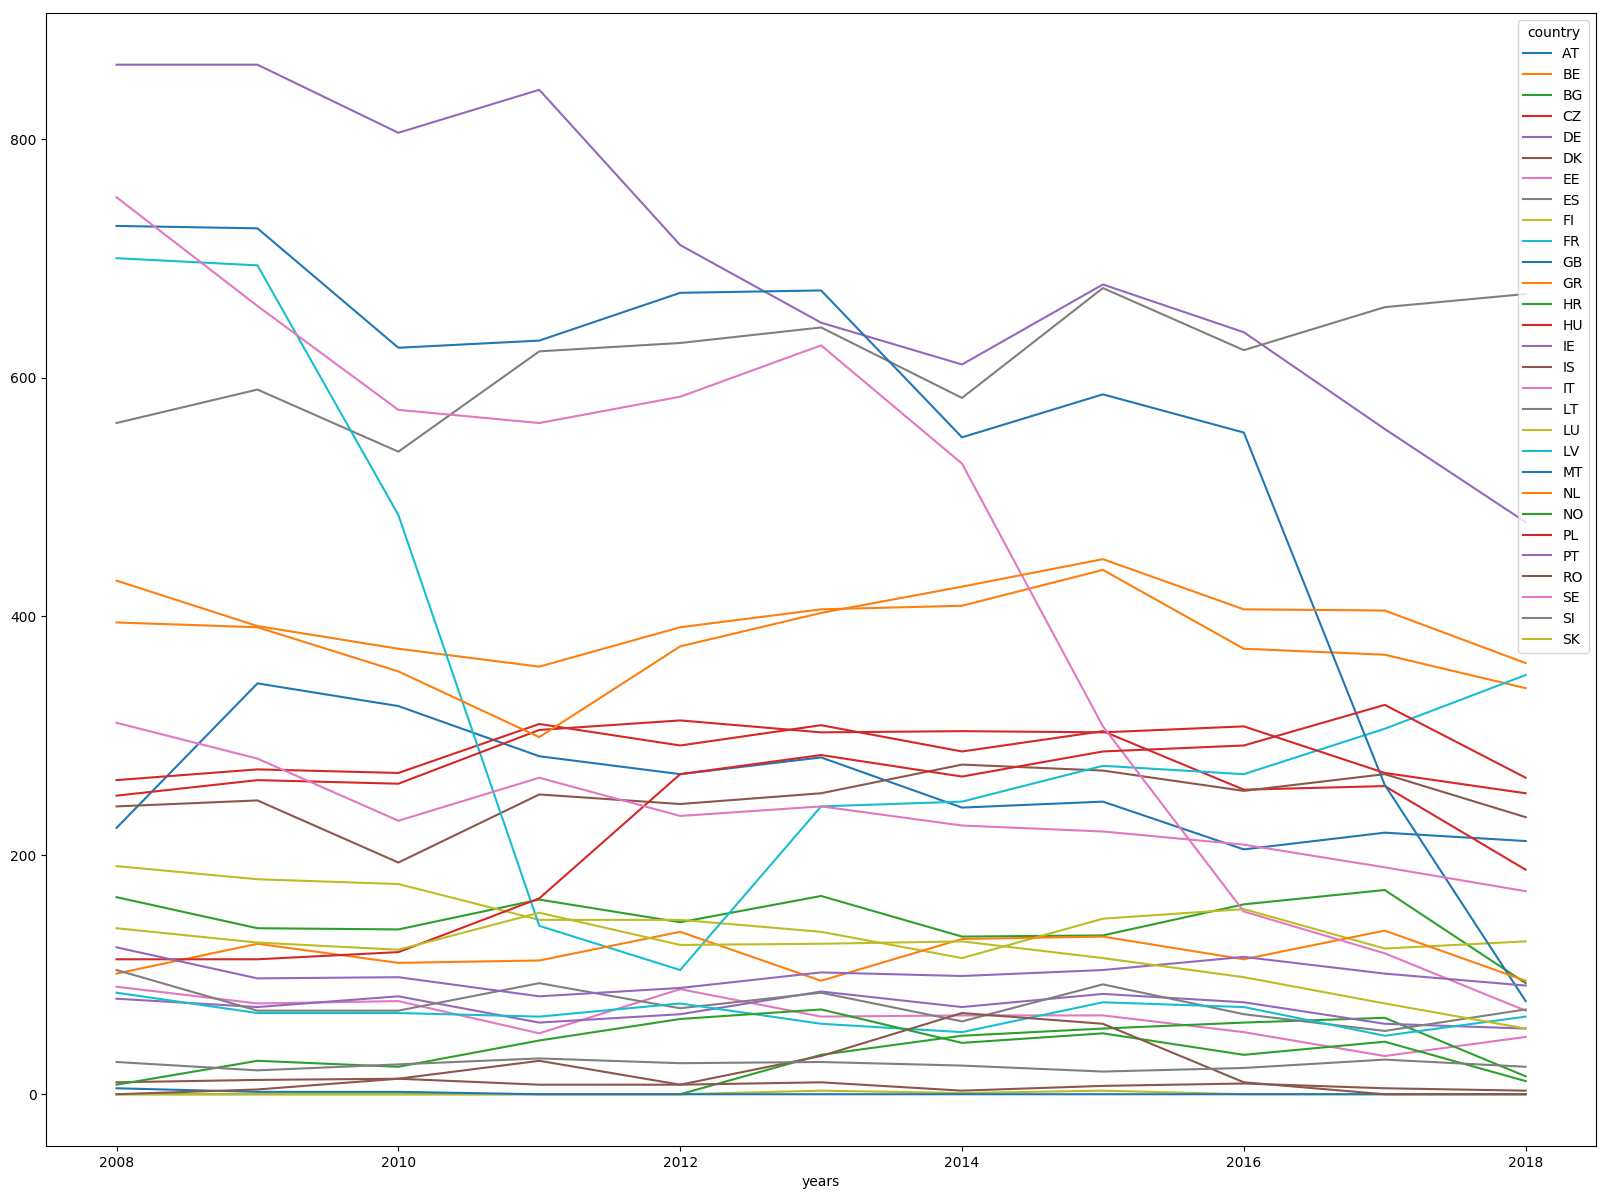

In [77]:
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
all_pivoted_cad.plot(ax=ax)

Scrap stuff - saving because I might need later or as a reference

In [60]:
def plot_countries(name, dataset, quarters = False):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(dataset.loc[:, 'FR' ], label = 'FR')
    ax.plot(dataset.loc[:, 'GB' ], label = 'GB')
    ax.plot(dataset.loc[:, 'DE' ], label = 'DE')
    ax.plot(dataset.loc[:, 'IT' ], label = 'IT')
    ax.plot(dataset.loc[:, 'ES' ], label = 'ES')
    ax.plot(dataset.loc[:, 'BE' ], label = 'BE')
    ax.plot(dataset.loc[:, 'NL' ], label = 'NL')
    ax.yaxis.grid(linestyle='--', linewidth=.25)
    ax.xaxis.grid(linestyle='--', linewidth=.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(name, fontsize = 20)
    plt.ylabel('# of Trials', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc='best', fontsize = 15)
    if quarters == False:
        plt.xticks(np.arange(min(list(dataset.index)), max(list(dataset.index))+1, 1.0))
    plt.show()

In [ ]:
def colormapgenerator(N, cm=None):
    base = plt.cm.get_cmap(cm)
    color_list = base(np.linspace(0, 1, N))
    cm_name = base.name + str(N)
    return base.from_list(cm_name, color_list, N)
print(colormapgenerator(20,cm='jet'))

In [ ]:
pivoted_entered.plot(figsize=(15,20), colormap=colormapgenerator(20,cm='rainbow'))

In [ ]:
fig, ax = plt.subplots(figsize=(35,40), dpi = 100)
ax.plot(pivoted_entered)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Trials by Date Entered on EudraCT", fontsize = 30)
plt.ylabel('# of Trials', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(np.arange(min(years_list), max(years_list)+1, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(countries, loc='upper center', bbox_to_anchor=(0.5, -0.02),
          fancybox=True, shadow=True, ncol=10, prop={'size':30})
plt.show()

In [ ]:
#some potential discrete colors
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#BC8F8F', '#000000']